# Project - Regressors

## Initialization

Import libraries

In [5]:
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, r2_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc

from operator import itemgetter, attrgetter

from matplotlib import pyplot as plt

#### Prepare parallel kernel

*Install [here](https://ipyparallel.readthedocs.io/en/latest/), define the number of engines and click '**Start**' in the* **iPython Clusters** *tab.*

Import parallel computing libraries and register processors

In [6]:
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
from joblib import Parallel, parallel_backend, register_parallel_backend

In [7]:
c = Client(profile='default')
print('profile:', c.profile)
print("IDs:", c.ids) # Process id numbers
bview = c.load_balanced_view()
register_parallel_backend('ipyparallel',
                          lambda : IPythonParallelBackend(view=bview))

profile: default
IDs: [0, 1, 2, 3]


---

## Function definitions

Read datasets

In [4]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [5]:
def pp_rf(test_size):
    
    list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(latest_file)

    df_raw = pd.read_csv(latest_file, index_col=0)
    df_raw.sort_index(inplace = True, ascending = True)
    df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

## Random Forest Classifier

We will compare two methods, which are grid search and random search.

In [6]:
X, X_train, X_test, y, y_train, y_test = pp_rf(0.3)

50_by_100\Full-2020_05_09-13_41_43-X_raw_disease_50_target_100_500_by_101.csv


In [7]:
clf = RandomForestRegressor(n_jobs=-1)

### Grid search

To avoid having too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

#### Max Depth

This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and increases computational time without much results) and 15.

#### Number of estimators

This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 100 and 5'000 and see the effects.

In [8]:
max_depth = list(range(4,16))

In [9]:
n_estimators = [100, 200, 500, 1000, 2000]

Let's use the default 5 folds of cross validation.

In [10]:
grid_parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators }

In [11]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, return_train_score=True, verbose = 3)

In [12]:
print(X_train.shape)
print(len(y_train))

(380, 100)
380


In [13]:
with parallel_backend('ipyparallel'):
    grid_clf.fit(X_train, y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Let's check which model is the best.

In [14]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {:.5}'.format(grid_best_score))
print('Best_max_depth: {}'.format(grid_best_max_depth))
print('Best_n_estimators: {}'.format(grid_best_n_estimators))

Grid search best_score: -1.2991
Best_max_depth: 12
Best_n_estimators: 100


In [15]:
grid_clf_best = RandomForestRegressor(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [16]:
grid_clf_best.fit(X_train, y_train);

Let's apply it to our validation set.

In [17]:
grid_y_pred = grid_clf_best.predict(X_test)

In [18]:
mape = abs(grid_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mape)))

Accuracy: -265.94%


Given this accuracy, we can take a deeper look into the results.

grid_cm = confusion_matrix(y_test, grid_y_pred)
index = ['Negative','Positive']  
columns = ['Negative','Positive']  
cm_df = pd.DataFrame(grid_cm,columns,index) 


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15);

#### Feature importance

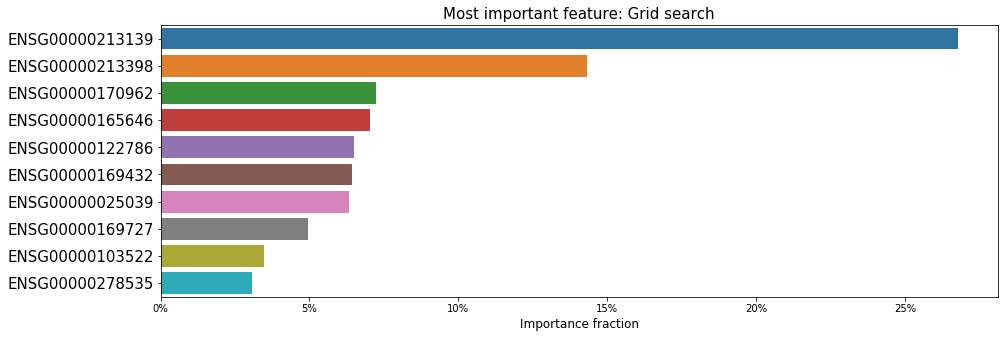

In [19]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [20]:
print(r2_score(y_test,grid_y_pred))

-0.25086036253318844


#### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [21]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_test_sel = X_test[grid_selected_features]

In [22]:
with parallel_backend('ipyparallel'):
    grid_clf.fit(grid_X_train_sel, y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


In [23]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {:.5}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

Grid search best_score with selected features: -1.0692
Grid search best_max_depth with selected features: 12
Grid search best_n_estimators with selected features: 100


In [24]:
grid_clf_best_sel = RandomForestRegressor(n_jobs = -1,
                                          max_depth = grid_best_max_depth_sel,
                                          n_estimators = grid_best_n_estimators_sel)

In [25]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train);

In [26]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_test_sel)

In [27]:
mape = abs(grid_y_pred_sel - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mape)))

Accuracy: -262.33%


In [28]:
print(r2_score(y_test,grid_y_pred_sel))

-0.2556040905074686


### Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [29]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [30]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [31]:
with parallel_backend('ipyparallel'):
    random_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [32]:
random_best_score = random_clf.best_score_
print('Random search best_score: {:.4}'.format(random_best_score))


Random search best_score: -0.5478


In [33]:
random_best_parameters = random_clf.best_params_
random_best_n_estimators = random_best_parameters.get('n_estimators')
random_best_min_samples_leaf = random_best_parameters.get('min_samples_leaf')
random_best_max_features = random_best_parameters.get('max_features')
random_best_max_depth = random_best_parameters.get('max_depth')

print('Best_n_estimators: {}'.format(random_best_n_estimators))
print('Best_min_samples_leaf: {}'.format(random_best_min_samples_leaf))
print('Best_max_features: {}'.format(random_best_max_features))
print('Best_max_depth: {}'.format(random_best_max_depth))


Best_n_estimators: 210
Best_min_samples_leaf: 14
Best_max_features: log2
Best_max_depth: 35


In [34]:
random_clf_best = RandomForestRegressor(n_jobs = -1,
                                        n_estimators = random_best_n_estimators,
                                        min_samples_leaf = random_best_min_samples_leaf,
                                        max_features = random_best_max_features,
                                        max_depth = random_best_max_depth)

In [35]:
random_clf_best.fit(X_train, y_train);

In [36]:
random_y_pred = random_clf_best.predict(X_test)

random_cm = confusion_matrix(y_test, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

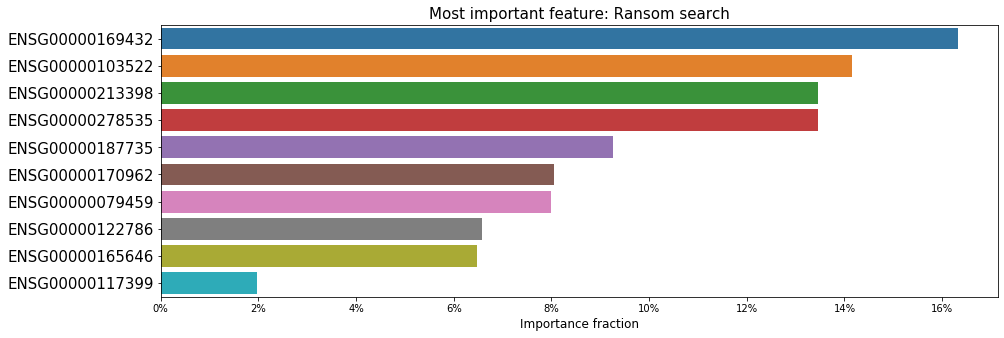

In [37]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [38]:
print(r2_score(y_test,random_y_pred))

0.0013314049489027147


In [39]:
random_mae = 100 * abs(random_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(100 - np.mean(mape)))

Accuracy: -25544.52%


### Comparison

#### ROC Curve

fpr_grid, tpr_grid, _ = roc_curve(y_test, grid_y_pred)
fpr_grid_sel, tpr_grid_sel, _ = roc_curve(y_test, grid_y_pred_sel)
fpr_random, tpr_random, _ = roc_curve(y_test, random_y_pred)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

roc_auc_grid = roc_auc_score(y_test, grid_y_pred)
print('ROC AUC for Grid Search: %.5f' % roc_auc_grid)
roc_auc_grid_sel = roc_auc_score(y_test, grid_y_pred_sel)
print('ROC AUC for Grid Search with selected predictors: %.5f' % roc_auc_grid_sel)
roc_auc_random = roc_auc_score(y_test, random_y_pred)
print('ROC AUC for Random Search: %.5f' % roc_auc_random)

We observe that all three methods are better than a random prediction. The Grid Search with Selected Predictors has slightly better prediction than the Random Search, which has in turn slightly better prediction than the basic Grid Search.

plt.figure(figsize=(12, 6))
plt.xlim(0.05, 0.15)
plt.ylim(0.4, 0.55)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### Precision - Recall Curve

grid_precision, grid_recall, _ = precision_recall_curve(y_test, grid_y_pred)
grid_precision_sel, grid_recall_sel, _ = precision_recall_curve(y_test, grid_y_pred_sel)
random_precision, random_recall, _ = precision_recall_curve(y_test, random_y_pred)

y_test = np.array(y_test)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(grid_recall, grid_precision, marker='.', label='Grid Search')
plt.plot(grid_recall_sel, grid_precision_sel, marker='.', label='Grid Search')
plt.plot(random_recall, random_precision, marker='.', label='Random Search')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

pr_auc_grid = auc(grid_recall, grid_precision)
print('Precision-Recall AUC for Grid Search: %.5f' % pr_auc_grid)
pr_auc_grid_sel = auc(grid_recall_sel, grid_precision_sel)
print('Precision-Recall AUC for Grid Search with selected predictors: %.5f' % pr_auc_grid_sel)
pr_auc_random = auc(random_recall, random_precision)
print('Precision-Recall AUC for Random Search: %.5f' % pr_auc_random)

# SVM Classifier

In [1]:
def pp_svm(test_size, df_raw):

    df_raw = pd.read_csv(latest_file, index_col=0)
    df_raw.sort_index(inplace = True, ascending = True)
    df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

In [ ]:
list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_raw = pd.read_csv(latest_file, index_col=0)
#########################
counts = []
counts2 = []

target_list = ['ENSG00000025039','ENSG00000048649','ENSG00000079459','ENSG00000102096'
               ,'ENSG00000102580','ENSG00000103522','ENSG00000117151','ENSG00000117399'
               ,'ENSG00000122786','ENSG00000131116','ENSG00000132821','ENSG00000141756'
               ,'ENSG00000165646','ENSG00000168734','ENSG00000169432','ENSG00000169727'
               ,'ENSG00000170962','ENSG00000175309','ENSG00000179082','ENSG00000180008'
               ,'ENSG00000184838','ENSG00000186599','ENSG00000187735','ENSG00000189090'
               ,'ENSG00000197601','ENSG00000197644','ENSG00000197978','ENSG00000199132'
               ,'ENSG00000201009','ENSG00000202245','ENSG00000204977','ENSG00000207947'
               ,'ENSG00000213139','ENSG00000213398','ENSG00000214460','ENSG00000221203'
               ,'ENSG00000221859','ENSG00000225797','ENSG00000226540','ENSG00000226690'
               ,'ENSG00000227155','ENSG00000228108','ENSG00000228289','ENSG00000230283'
               ,'ENSG00000230606','ENSG00000231565','ENSG00000232675','ENSG00000234275'
               ,'ENSG00000234394','ENSG00000235795','ENSG00000236523','ENSG00000237092'
               ,'ENSG00000237283','ENSG00000237767','ENSG00000237927','ENSG00000243864'
               ,'ENSG00000244335','ENSG00000244748','ENSG00000248266','ENSG00000249453'
               ,'ENSG00000249532','ENSG00000250173','ENSG00000251333','ENSG00000252437'
               ,'ENSG00000253089','ENSG00000255437','ENSG00000256238','ENSG00000257541'
               ,'ENSG00000257915','ENSG00000259047','ENSG00000259607','ENSG00000261659'
               ,'ENSG00000261669','ENSG00000263616','ENSG00000267393','ENSG00000267575'
               ,'ENSG00000269179','ENSG00000271220','ENSG00000272430','ENSG00000274263'
               ,'ENSG00000274630','ENSG00000274866','ENSG00000275128','ENSG00000275360'
               ,'ENSG00000275538','ENSG00000276232','ENSG00000276291','ENSG00000278535'
               ,'ENSG00000278593','ENSG00000278963','ENSG00000279142','ENSG00000279454'
               ,'ENSG00000279774','ENSG00000279861','ENSG00000283202','ENSG00000284416'
               ,'ENSG00000287234','ENSG00000287291','ENSG00000287329','ENSG00000287565']

for tar in target_list:
    counter = 0
    test = []
    for index, row in df_raw.iterrows() :
        test.append(row[tar])
    for item in test:
        if item != 0.0:
            counter += 1
    counts.append([tar,counter])
    counts2.append(counter)
#################

# on prend les 3 targets qui on le max de features
final_list = []

for item in counts:
    if item[1] == 233:
        final_list.append(item[0])
    if item[1] == 222:
        final_list.append(item[0])
    if item[1] == 209:
        final_list.append(item[0])
#################

# modifions le df
for tar in target_list:
    if tar != target_list[8] and tar != target_list[14] and tar != target_list[33]:
        df_raw = df_raw.drop(tar, axis=1)
df_raw.head()

In [ ]:
X, X_train, X_test, y, y_train, y_test = pp_svm(0.3, df_raw)

In [ ]:
clf = SVR(gamma='scale', C=2)
with parallel_backend('ipyparallel'):
    clf.fit(X_train,y_train);
y_predict = clf.predict(X_test)

In [ ]:
mape = abs(y_predict - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mape)))

# NETWORK

In [13]:
###########################
raw_kaggle_data = pd.read_csv('COVID_KG_sample.csv')
raw_kaggle_data.head()
train_set = raw_kaggle_data[raw_kaggle_data['predicate']!='hasGeneticClue'].values
genetic_clue_triples = raw_kaggle_data[raw_kaggle_data['predicate']=='hasGeneticClue']

In [14]:
# Generating network file
genetic_clue_triples = raw_kaggle_data[raw_kaggle_data['predicate']=='hasGeneticClue']
genetic_clue_triples = genetic_clue_triples.drop("predicate", axis=1)
print(type(genetic_clue_triples))

<class 'pandas.core.frame.DataFrame'>


In [15]:
%matplotlib inline
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
network_df = genetic_clue_triples.values.tolist()
with open('network_file.txt', 'w') as network_file:
    for listitem in network_df:
        network_file.write('%s' % listitem[0])
        network_file.write(' %s\n' % listitem[1])

In [17]:
# read edgelist from the txt file
Graph = nx.read_edgelist('network_file.txt')

In [39]:
print(type(Graph))

<class 'networkx.classes.graph.Graph'>


In [18]:
print('Number of nodes: {}'.format(len(Graph.nodes)))
print('Number of edges: {}'.format(len(Graph.edges)))

Number of nodes: 5318
Number of edges: 103103


In [19]:
# infos dict initialization
Graph_infos = {}

In [20]:
# Degree (number of edges at each node) for all nodes in order to have the main stats (max,min,meand,median,quantile) and plot

Graph_infos['Degrees'] = dict(nx.degree(Graph))

# only values
degrees_val = [Graph_infos['Degrees'][node] for node in Graph_infos['Degrees']]

#stats
degree_min = np.min(degrees_val)
print('Min degree connection: {}'.format(degree_min))
print('')

degree_max = np.max(degrees_val)
print('Max degree connection: {}'.format(degree_max))
print('')

degree_median = np.median(degrees_val)
print('Median degree connection: {}'.format(degree_median))
print('')

degree_mean = np.mean(degrees_val)
print('Mean degree connection: {}'.format(degree_mean))
print('')

degree_u_quant = np.quantile(degrees_val,0.75)
print('75% quantile degree connection: {}'.format(degree_u_quant))
print('')

degree_l_quant = np.quantile(degrees_val,0.25)
print('25% quantile degree connection: {}'.format(degree_l_quant))
print('')

Min degree connection: 1

Max degree connection: 755

Median degree connection: 6.0

Mean degree connection: 38.77510342233923

75% quantile degree connection: 26.0

25% quantile degree connection: 2.0



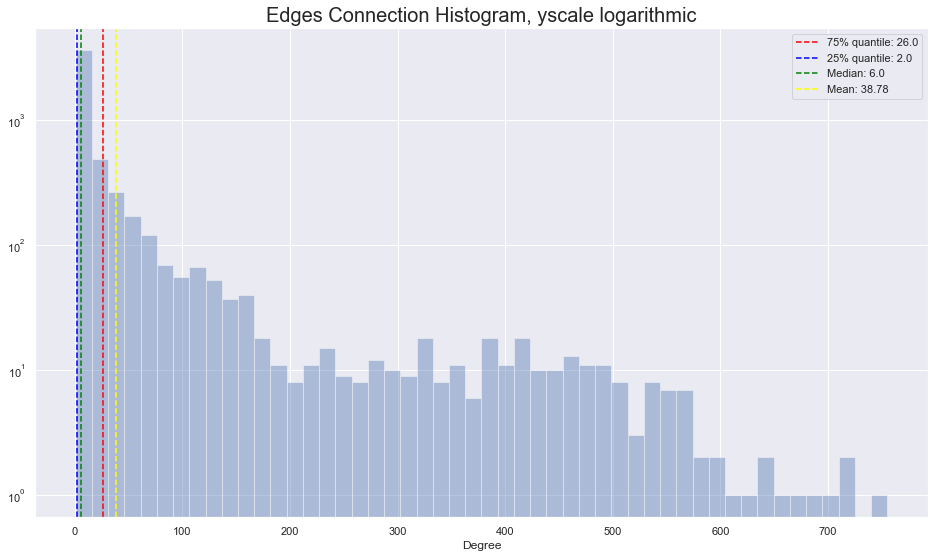

In [21]:
# Degree histogram
plt.figure(figsize=(16,9)) 
sns.set() 
 
sns.distplot(degrees_val,axlabel="Degree",kde=False)

plt.axvline(degree_u_quant, color = 'red', linestyle = '--', label = '75% quantile: {}'.format(degree_u_quant))
plt.axvline(degree_l_quant, color = 'blue', linestyle = '--', label = '25% quantile: {}'.format(degree_l_quant))
plt.axvline(degree_median, color = 'green', linestyle = '--', label = 'Median: {}'.format(degree_median))
plt.axvline(degree_mean, color = 'yellow', linestyle = '--', label = 'Mean: {}'.format(round(degree_mean,2)))
plt.legend()
plt.yscale('log')
plt.title("Edges Connection Histogram, yscale logarithmic", fontsize = 20) # for histogram title
plt.legend()

In [22]:
# Calculate for each node the triangles they are involved in as well as the main stats like above
Graph_infos['Triangles'] = nx.triangles(Graph)

# values only
triangles_val = [Graph_infos['Triangles'][i] for i in Graph_infos['Triangles']]

# stats
triangles_min = np.min(triangles_val)
print('Min triangles connection from a node: {}'.format(triangles_min))
print('')
triangles_max = np.max(triangles_val)
print('Max triangles connection from a node: {}'.format(triangles_max))
print('')

triangles_median = np.median(triangles_val)
print('Median triangles connection from a node: {}'.format(triangles_median))
print('')
triangles_mean = np.mean(triangles_val)
print('Mean triangles connection from a node: {}'.format(triangles_mean))
print('')

triangles_u_quant = np.quantile(triangles_val,0.75)
print('75% quantile triangle connection from a node: {}'.format(triangles_u_quant))
print('')
triangles_l_quant = np.quantile(triangles_val,0.25)
print('25% quantile triangle connection from a node: {}'.format(triangles_l_quant))
print('')

Min triangles connection from a node: 0

Max triangles connection from a node: 44343

Median triangles connection from a node: 8.0

Mean triangles connection from a node: 1364.1871004136894

75% quantile triangle connection from a node: 184.75

25% quantile triangle connection from a node: 0.0



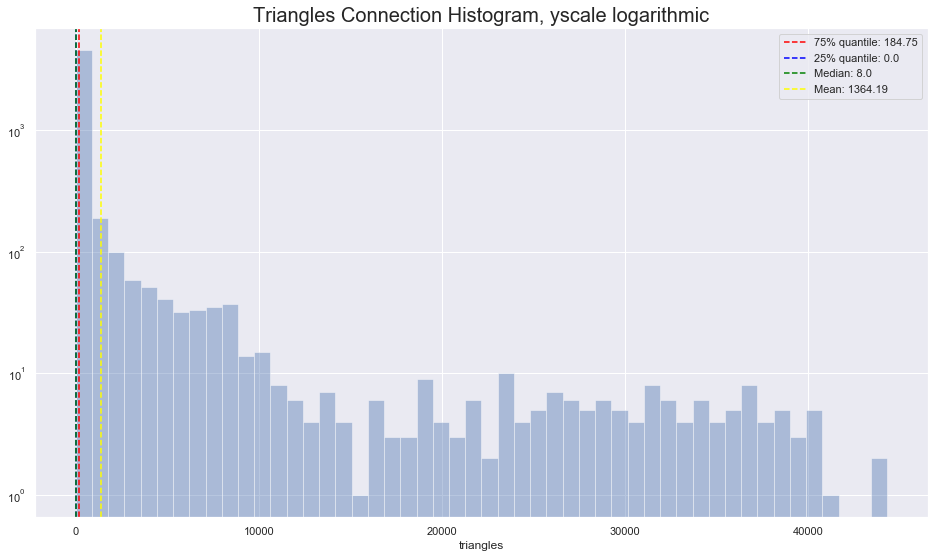

In [23]:
# plot triangle distribution
plt.figure(figsize=(16,9)) 
sns.set() 
 
sns.distplot(triangles_val,axlabel="triangles",kde=False)

plt.axvline(triangles_u_quant, color = 'red', linestyle = '--', label = '75% quantile: {}'.format(triangles_u_quant))
plt.axvline(triangles_l_quant, color = 'blue', linestyle = '--', label = '25% quantile: {}'.format(triangles_l_quant))
plt.axvline(triangles_median, color = 'green', linestyle = '--', label = 'Median: {}'.format(triangles_median))
plt.axvline(triangles_mean, color = 'yellow', linestyle = '--', label = 'Mean: {}'.format(round(triangles_mean,2)))
plt.legend()
plt.yscale('log')
plt.title("Triangles Connection Histogram, yscale logarithmic", fontsize = 20) 
plt.legend()

In [24]:
Graph_centrality = {}
deg_cen = dict(nx.degree_centrality(Graph))

In [25]:
Graph_centrality['Degree Centrality'] = deg_cen
clo_cen = nx.closeness_centrality(Graph)

In [26]:
Graph_centrality['Closeness Centrality'] = clo_cen
bw_cen = nx.betweenness_centrality(Graph)

In [27]:
Graph_centrality['Betweeness Centrality'] = bw_cen
pr_cen = nx.pagerank(Graph)

In [28]:
Graph_centrality['Pagerank Centrality'] = pr_cen
eig_cen = nx.eigenvector_centrality(Graph)
Graph_centrality['Eigenvector Centrality'] = eig_cen

In [29]:
# in order to sort dicitonaries
import operator

In [30]:
#list to dict function
def list_to_dict(a):
    d = {a[j][0]:a[j][1] for j in range(len(a)) }

    return d

In [31]:
# print top 10 nodes for given centrality measure
def top_print(name,centrality,n):
    
    # sort the centrality to have the best above
    ranked_list = sorted(centrality.items(),key = operator.itemgetter(1),reverse = True)
    ranked_dict = list_to_dict(ranked_list)
    print(' ')
    print("CENTRALITY MEASURE BY {}".format(name.upper()))
    for k in range(0,n):
        # depends for decimals or not
        if ranked_list[k][1] > 1:
            print("{}. {} has a centrality of {:.0F}".format(k+1,ranked_list[k][0],ranked_list[k][1]))
        else:
            print("{}. {} has a centrality of {:.5F}".format(k+1,ranked_list[k][0],ranked_list[k][1]))
        k = k+1

In [32]:
#execute function
for k in Graph_centrality:
    centrality = Graph_centrality[k]
    name = k
    top_print(name,centrality,10)

 
CENTRALITY MEASURE BY DEGREE CENTRALITY
1. EFO_1001461 has a centrality of 0.14200
2. EFO_0000558 has a centrality of 0.13598
3. MONDO_0002363 has a centrality of 0.13504
4. EFO_0000662 has a centrality of 0.13278
5. EFO_0000536 has a centrality of 0.12902
6. EFO_1001047 has a centrality of 0.12733
7. EFO_0005221 has a centrality of 0.12375
8. EFO_0002893 has a centrality of 0.12187
9. EFO_0000668 has a centrality of 0.12018
10. EFO_0003106 has a centrality of 0.11698
 
CENTRALITY MEASURE BY CLOSENESS CENTRALITY
1. EFO_1001047 has a centrality of 0.46454
2. Orphanet_70589 has a centrality of 0.46116
3. EFO_0000769 has a centrality of 0.45881
4. MONDO_0001751 has a centrality of 0.45668
5. EFO_1001461 has a centrality of 0.45660
6. MONDO_0019956 has a centrality of 0.45609
7. EFO_0003106 has a centrality of 0.45574
8. EFO_0005762 has a centrality of 0.45445
9. EFO_0009373 has a centrality of 0.45406
10. EFO_0009910 has a centrality of 0.45310
 
CENTRALITY MEASURE BY BETWEENESS CENTRAL

In [33]:
def overall_ranking(G, G_centrality, n_top, G_infos):
    ''' G: Graph
        G_centrality: centralities dict 
        n_top (int): number of nodes to be printed
        G_infos (dict)'''
    
    centralities = list(G_centrality.keys())
    
    # dict in order to have the ranking {best node 1: 1, best node 2: 2} for each centrality
    centrality_ranked = {}
    
    # for each key in the overall_rank dict, have the ranking they have in each centrality
    overall_rank = {n: [] for n in G.nodes}

    for cen in centralities:

        ranking = sorted(G_centrality[cen].items(),key = operator.itemgetter(1),reverse = True)
        
        centrality_ranked[cen] = {ranking[n][0]: n+1 for n in range(0,len(ranking))}
        
        for node in G.nodes:
            overall_rank[node].append(centrality_ranked[cen][node])
        
    # sum the points each nodes earned in the ranking in the centralities
    total = {node: np.sum(overall_rank[node]) for node in G.nodes}
    
    # sort in order to have the n_tops nodes in increasing order
    total_ranking = sorted(total.items(),key = operator.itemgetter(1),reverse = False)
    
    top_nodes = [total_ranking[i][0] for i in range(n_top)]
    
    print('OVERALL RANKING')

        
    for i in range(len(top_nodes)):
        node = top_nodes[i]
        print('')
        print('------------------')
        print('Node: {}'.format(node))
        print('')
        print('No: {} in centrality overall ranking'.format(i+1))
        print('')
        print('Specificity:')
        print('')
        print('Number of connections: {}'.format(G_infos['Degrees'][node]))
        print('Number of triangles involved in: {}'.format(G_infos['Triangles'][node]))
        
        print('')
        for j in range(len(centralities)):
            print('No: {} in {} ranking'.format(overall_rank[node][j], str(centralities[j])))
        print
        
    return centrality_ranked, total_ranking

In [34]:
centrality_ranked,total_ranking = overall_ranking(Graph, Graph_centrality,3, Graph_infos)

OVERALL RANKING

------------------
Node: EFO_0000662

No: 1 in centrality overall ranking

Specificity:

Number of connections: 706
Number of triangles involved in: 44343

No: 4 in Degree Centrality ranking
No: 13 in Closeness Centrality ranking
No: 51 in Betweeness Centrality ranking
No: 35 in Pagerank Centrality ranking
No: 1 in Eigenvector Centrality ranking

------------------
Node: EFO_0000668

No: 2 in centrality overall ranking

Specificity:

Number of connections: 639
Number of triangles involved in: 39584

No: 9 in Degree Centrality ranking
No: 22 in Closeness Centrality ranking
No: 46 in Betweeness Centrality ranking
No: 37 in Pagerank Centrality ranking
No: 10 in Eigenvector Centrality ranking

------------------
Node: EFO_0000536

No: 3 in centrality overall ranking

Specificity:

Number of connections: 686
Number of triangles involved in: 38196

No: 5 in Degree Centrality ranking
No: 35 in Closeness Centrality ranking
No: 56 in Betweeness Centrality ranking
No: 34 in Page

In [35]:
def draw_graph_top(G,centrality_ranked,n, layout, name):
    
    plt.figure(figsize=(15,15))
    
    # draw base etwork 
    nx.draw_networkx(G, pos = layout, node_size = 30, with_labels = False, node_color = 'grey', edge_color = '0.7')
    
    # add bigger nodes in color
    
    top_nodes = list(centrality_ranked.keys())[:n]
    labels = {i: i for i in top_nodes}
    colors = ['#1ECD3F', '#0C437E', '#30F77B', '#E0016D', '#E0C6F4', '#A402CF', '#6C5020', '#014F05', '#3636DE', '#0E82F6']
    big_size = 3000
    sizes = [big_size/(i+1) for i in range(n)]
        
    nx.draw_networkx_nodes(G,pos=layout,nodelist= top_nodes, with_labels = True, node_color=colors, node_size = sizes)
        
    nx.draw_networkx_labels(G,layout, labels,font_size=16, font_color = 'white') 
    
    
    plt.title(name, fontsize = 20)
    plt.axis("off")

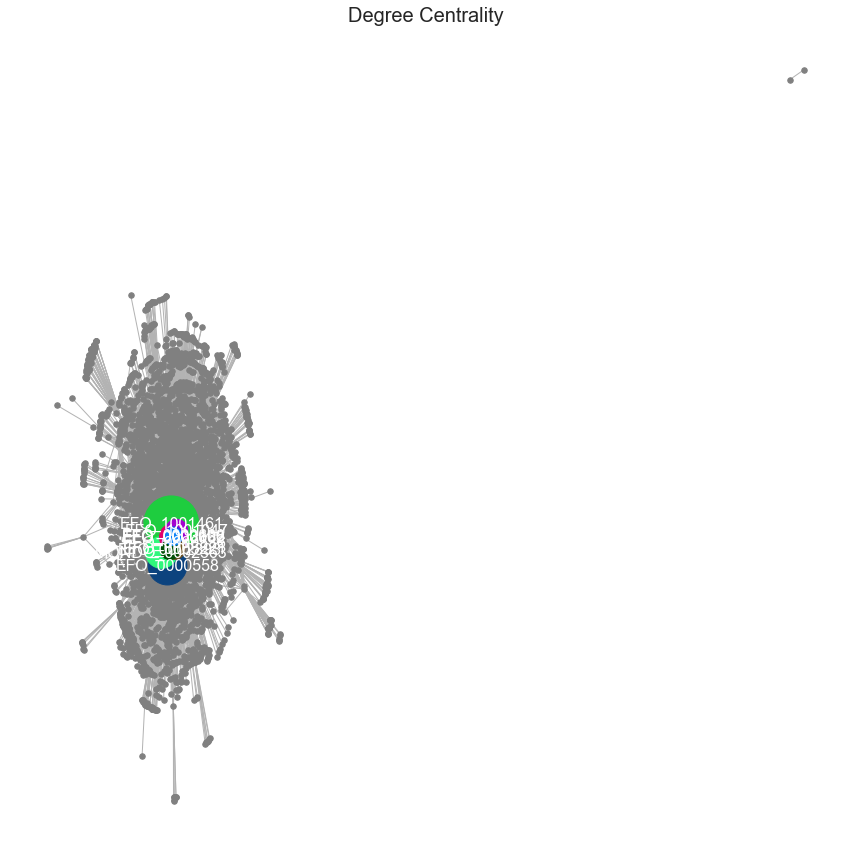

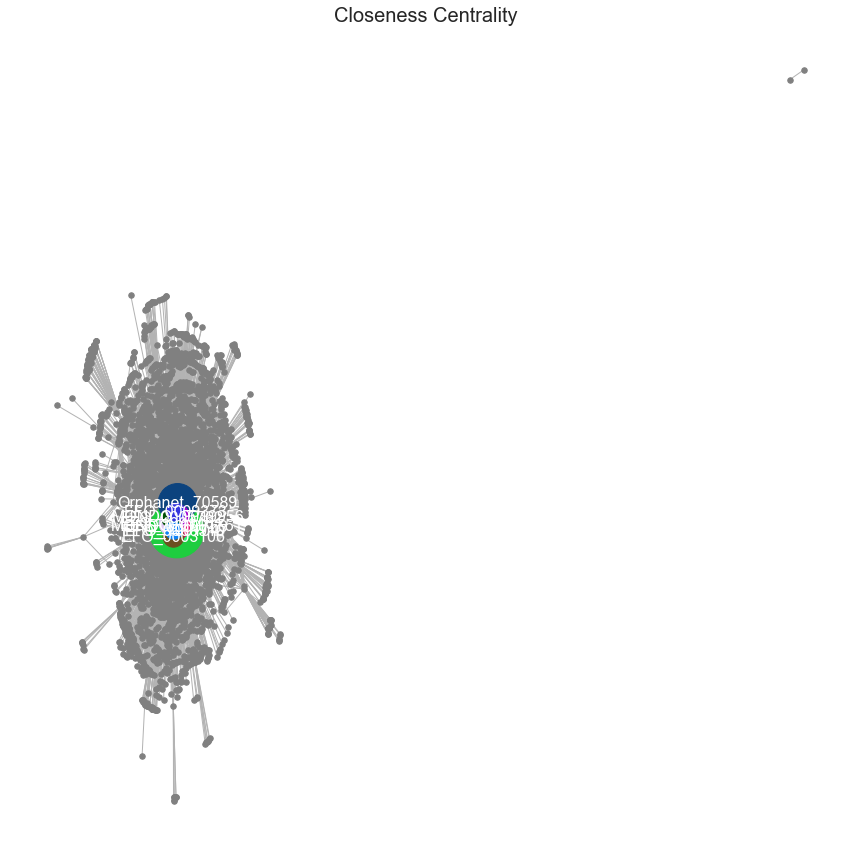

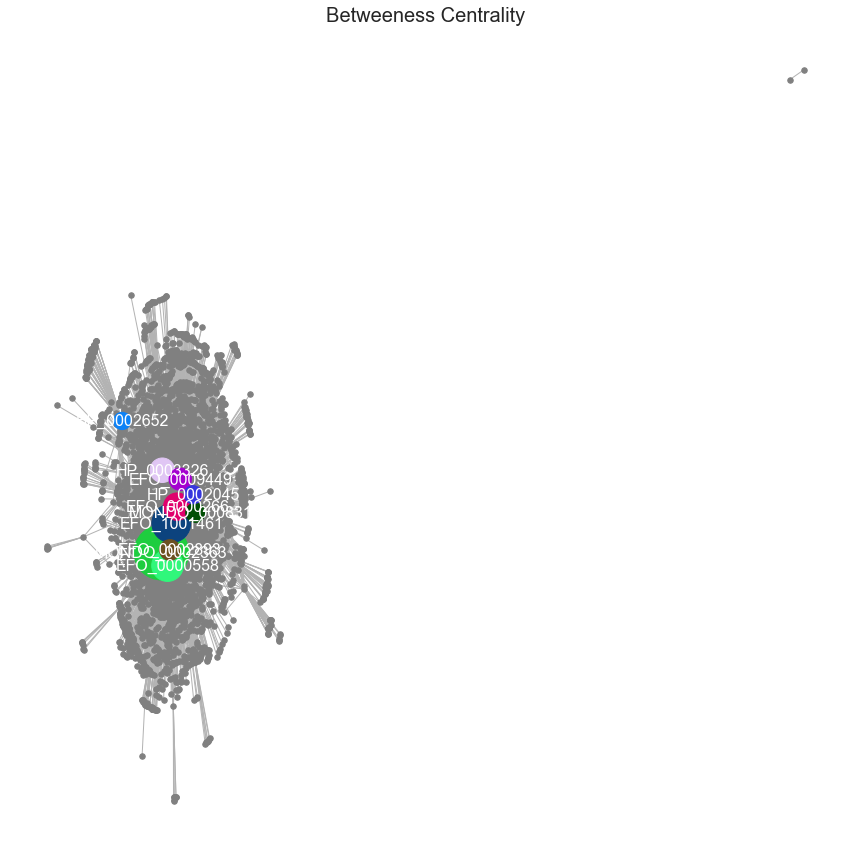

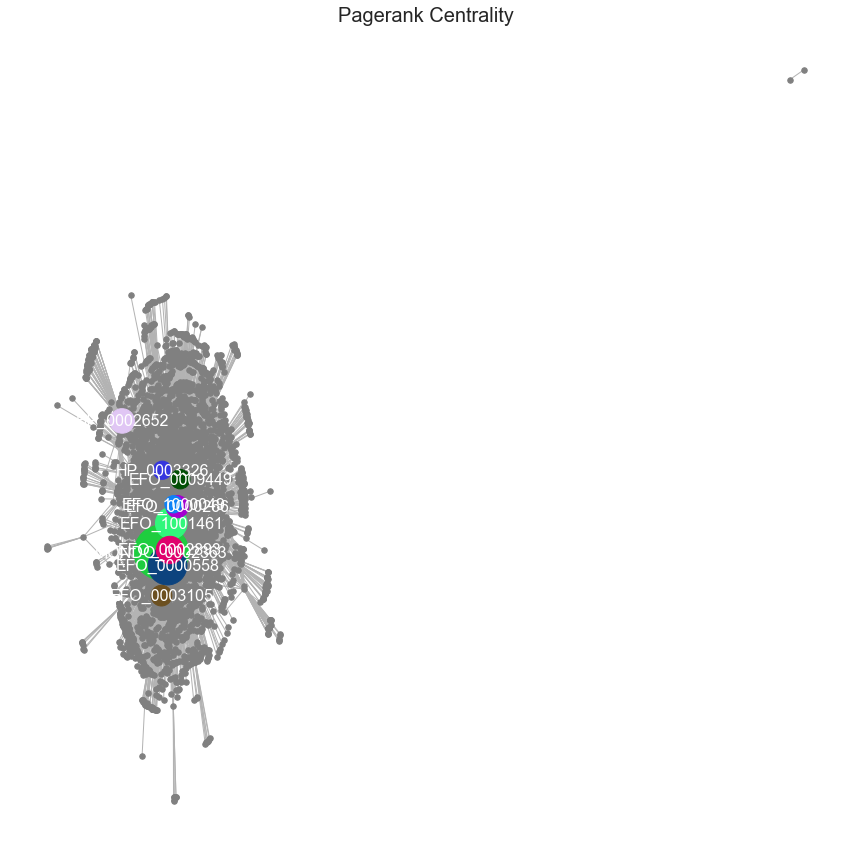

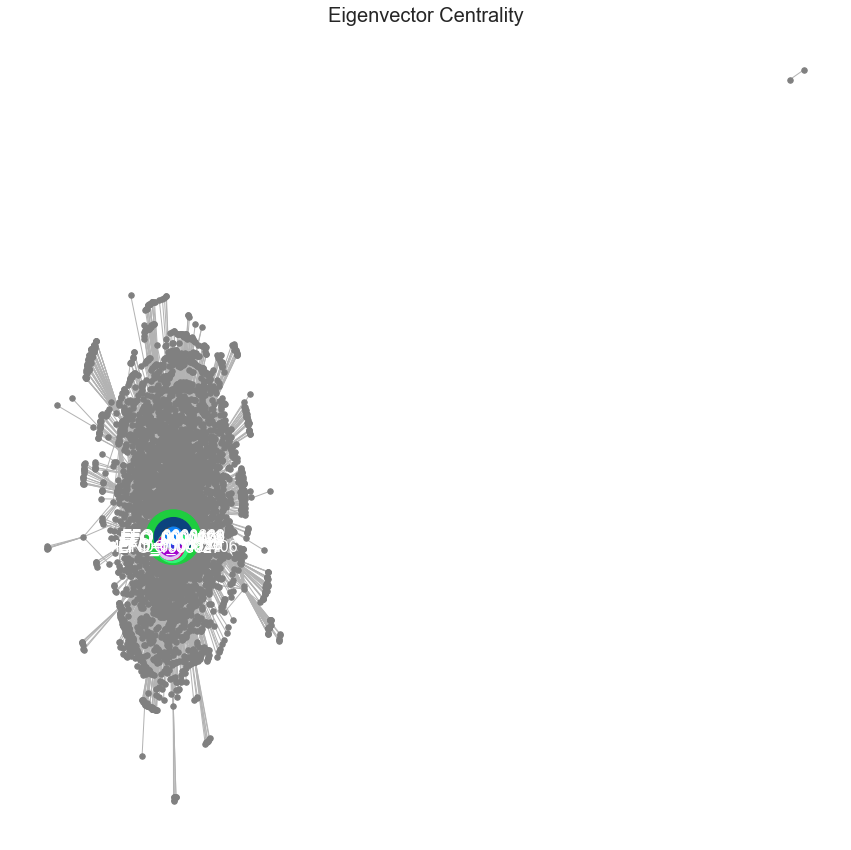

In [36]:
layout = nx.spring_layout(Graph)
for cen in Graph_centrality.keys():
    draw_graph_top(Graph,centrality_ranked[cen],10, layout, str(cen))

   

AttributeError: 'NoneType' object has no attribute 'edges'

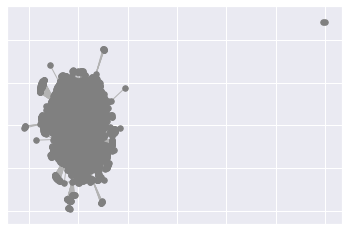

In [47]:
layout = nx.spring_layout(Graph)

graph_names = ['Degree.gexf', 'Closeness.gexf', 'Betweeness.gexf', 'Pagerank.gexf', 'Eigenvector.gexf']
for nm, cen in zip(graph_names, Graph_centrality.keys()):
    g = nx.draw_networkx(Graph, pos = layout, node_size = 30, with_labels = False, node_color = 'grey', edge_color = '0.7')
    nx.write_gexf(g, nm)